<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Week-1-Analysis" data-toc-modified-id="Week-1-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Week 1 Analysis</a></span><ul class="toc-item"><li><span><a href="#Step-5:-Flushing-Cell-with-N2-for-calibration" data-toc-modified-id="Step-5:-Flushing-Cell-with-N2-for-calibration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Step 5: Flushing Cell with N2 for calibration</a></span></li></ul></li></ul></div>

In [137]:
import re
import sys
import os
#sys.path.insert(0, '../..')
#os.chdir('../../../')

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from scipy.fftpack import fft, fftshift

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]

# Helper Functions

In [138]:
POWERS2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
MAX_WAVENUMBER = 15802


class Interferogram:
    """Interferogram class for all data processing, plotting, and saving. 


    Attributes:
        dir: directory holding data file
        filename: filename holding data
        datestamp: datestamp recording when data was taken
    """
    
    def __init__(self, DIR, filename):
        self.dir = DIR
        self.filename = filename
        
        with open(DIR+filename) as f:
            data = f.read().splitlines() 
        
        # Read in params at the top of the file
        self.datestamp = data[0].replace("#","").strip()
        result = re.search(r'\d+', data[1])
        self.res = int(result.group())
        result = re.search(r'\d+', data[2])
        self.vel = int(result.group())
        result = re.search(r'\d+', data[3])
        self.LP = int(result.group())
        result = re.search(r'\d+', data[4])
        self.HP = int(result.group())
        result = re.search(r'\d+', data[5])
        self.gain = int(result.group())
        
        # Read in the raw spectrum data
        raw = list(filter(None, data[6:]))
        scan_idx = [i for i in range(0, len(raw)) if "#" in raw[i]] + [len(raw)]
        self.raw_data = np.array(
            [np.array(raw[scan_idx[i]+1:scan_idx[i+1]], dtype=np.float) for i in range(0, len(scan_idx)-1)]
        )
        self.num_acq = len(self.raw_data)
        
        # Find the wavenumbers
        self.num_pts = [int(len(self.raw_data[i])/2) for i in range(0, self.num_acq)]
        self.wavenumbers = np.array(
            [2*np.linspace(0, MAX_WAVENUMBER, num=self.num_pts[i]) for i in range(0, self.num_acq)]
        )

        # Find the spectra
        mean = np.mean(np.array([x for x in raw if "#" not in x], dtype=np.float))
        self.spectra = self.fft(mean)

        
    def dictify(self):
        return {
            "filename": self.filename,
            "datestamp": self.datestamp,
            "resolution": self.res,
            "velocity": self.vel,
            "LP": self.LP,
            "HP": self.HP,
            "gain": self.gain
        }
    
    
    def fft(self, mean):
        """
        Calculates the spectra of the interferogram
        
        Args:
            interferogram2: The test sample spectrum, a np.array

        Returns:
            A numpy array of transmittances. 
        
        Raises:
            AssertionError: An error occurred if resolutions are different
        """
        new_data = []

        for line in self.raw_data:
            
            # Normalize data
            new_line = Interferogram.normalize_raw_data(line, mean)
            
            # Zero fill the data
            new_line = Interferogram.zero_fill(new_line)
            
            # Find the phase corrections
            re_phase, im_phase = self.mertz(new_line)
            
            # fft the interferogram
            re_inter, im_inter = Interferogram.fft_interferogram(line)
            
            # Add in the correction
            re_spectra = np.multiply(re_phase, re_inter)
            im_spectra = np.multiply(im_phase, im_inter)
            
            # Find the combined spectra
            spectra = np.add(re_spectra, 1j*im_spectra)
            
            # Record data
            new_data.append(np.absolute(spectra))
        
        return np.array(new_data)
        

    def mertz(self, data):
        """
        Returns the phase correction data
        The real and imaginary data arrays are multiplied by the power spectrum 
        """
        # find burtst location
        burst = np.argmax(data)
        
        # TODO: What do you do with the empty array?
        # Add the apodization triangular phase correction
        # new_line = np.multiply(new_line, Interferogram.triangular_signal(burst, len(new_line)))
        
        # Slicing to rotate about ZPD
        data = np.concatenate((data[burst:], data[:burst]))
        
        # data is FFT'd, producing real and imaginary data arrays.
        ffted = np.fft.fft(data)
        im_data = ffted.imag
        re_data = ffted.real
        
        # Find power spectrum
        power = np.absolute(ffted)
        
        # Normalization?
        #power = power / np.trapz(power[0:self.num_pts], self.wavenumbers)
        
        # The real and imaginary data arrays are multiplied by the power spectrum 
        return np.multiply(re_data, power), np.multiply(im_data, power)


    @staticmethod
    def fft_interferogram(data):
        """
        Do the fft for the interferogram, including the apodization, etc. 
        """
        
        # find burtst location
        burst = np.argmax(data)
        
        # apodize
        #data = Interferogram.apodize(burst, data)
        
        # zero fill
        data = Interferogram.zero_fill(data)
        
        # Slicing to rotate about ZPD
        data = np.concatenate((data[burst:], data[:burst]))
        
        # data is FFT'd, producing real and imaginary data arrays.
        ffted = np.fft.fft(data)
        return ffted.real, ffted.imag
    
    
    @staticmethod
    def zero_fill(data):
        """
        FFT requires number of points in the interferogram be a power of 2.
        If it is not, then the size of the array is increased to the next higher power of 2 
        and the added points are set to 0. 
        """
        for i in range(10, len(POWERS2)):
            if POWERS2[i] >= len(data):
                break
        return np.concatenate((data, np.zeros(POWERS2[i]-len(data))))
    
    
    @staticmethod
    def normalize_raw_data(data, mean):
        """The mean of the data is subtracted from the data, brings baseline of data to 0"""
        return data - mean
    
    @staticmethod
    def apodize(burst, data):
        return np.multiply(data, Interferogram.triangular_signal(burst, len(data)))
    
    @staticmethod
    def triangular_signal(center, total_len):
        window = signal.triang(2*center-1)
        return np.concatenate((window, np.zeros(total_len-len(window))))
    
    @staticmethod
    def calc_transmittance(interferogram1, interferogram2):
        """
        Calculates the transmittance per wavenumber
        
        Args:
            interferogram1: The background spectrum, a np.array
            interferogram2: The test sample spectrum, a np.array

        Returns:
            A numpy array of transmittances. 
        
        Raises:
            AssertionError: An error occurred if resolutions are different
        """
        assert (len(interferogram1) == len(interferogram2)), 'Background spectrum has {} pts, sample spectrum has {} pts'.format(len(interferogram1), len(interferogram2))
        return np.divide(interferogram2, interferogram1)
    
        
    @staticmethod
    def calc_absorbance(transmittance):
        """
        Calculates the absorbance per wavenumber
        
        Args:
            transmittance: array of transmittances

        Returns:
            A numpy array of absorbances. 
        """
        return -np.log(transmittance)

# Week 1 Analysis

In [139]:
DIR = "week1/"

## Step 5: Flushing Cell with N2 for calibration

In [140]:
#filename = "week1_step5_n2_flush.txt"
filename = "week1_centering.txt"
curr = Interferogram(DIR, filename)

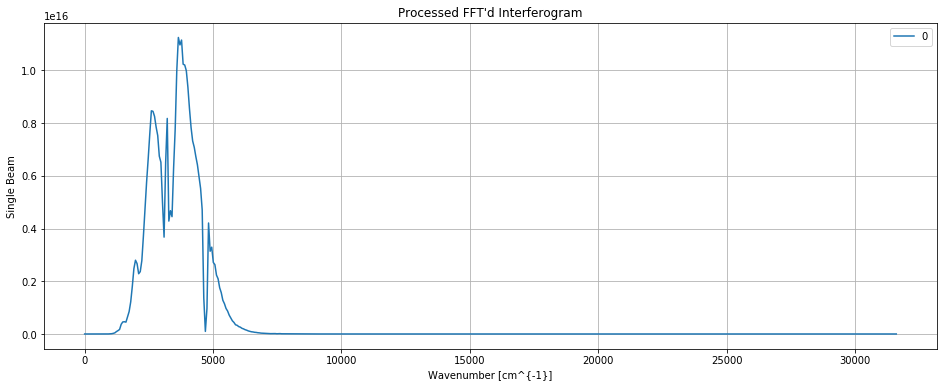

In [141]:
# 

# The FT'd result
plt.figure()
for i in range(0, 1):
    plt.plot(curr.wavenumbers[i], curr.spectra[i][:len(curr.wavenumbers[i])], label=str(i))
plt.grid(True)
plt.xlabel("Wavenumber [cm^{-1}]")
plt.ylabel("Single Beam")
plt.title("Processed FFT'd Interferogram")
plt.legend()
plt.show()

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in true_divide


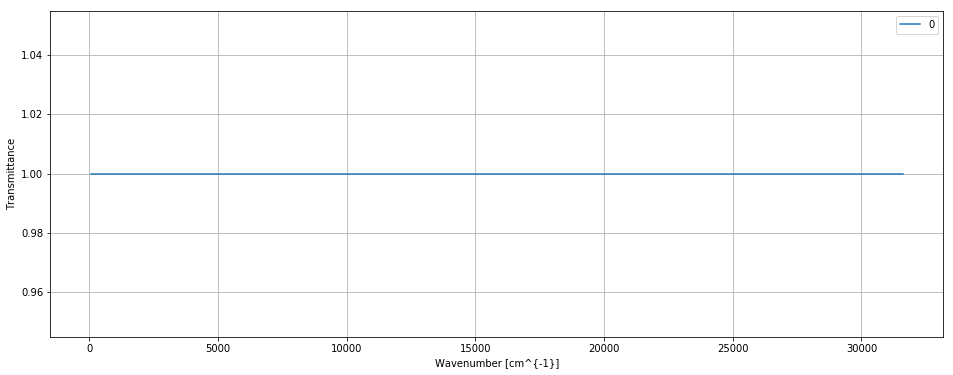

In [142]:
plt.figure()
for i in range(0, curr.num_acq):
    plt.plot(curr.wavenumbers[i], Interferogram.calc_transmittance(curr.spectra[0][:len(curr.wavenumbers[i])], curr.spectra[0][:len(curr.wavenumbers[i])]), label=str(i))
plt.grid(True)
plt.xlabel("Wavenumber [cm^{-1}]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in true_divide


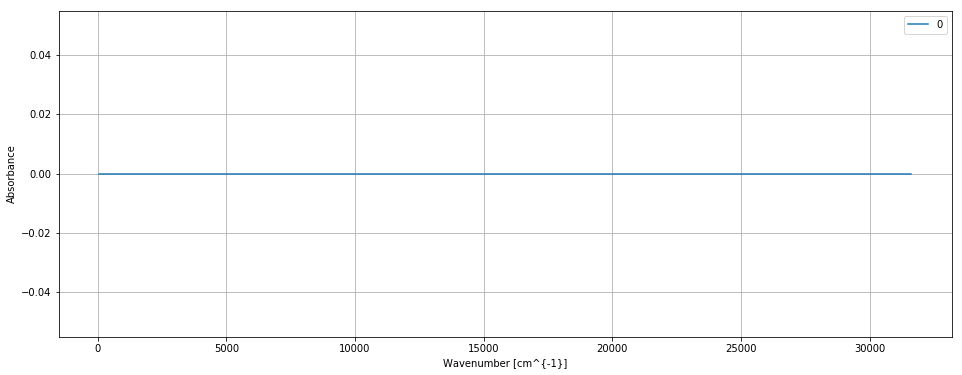

In [143]:
plt.figure()
for i in range(0, curr.num_acq):
    plt.plot(curr.wavenumbers[i], Interferogram.calc_absorbance(Interferogram.calc_transmittance(curr.spectra[0][:len(curr.wavenumbers[i])], curr.spectra[0][:len(curr.wavenumbers[i])])), label=str(i))
plt.grid(True)
plt.xlabel("Wavenumber [cm^{-1}]")
plt.ylabel("Absorbance")
plt.legend()
plt.show()

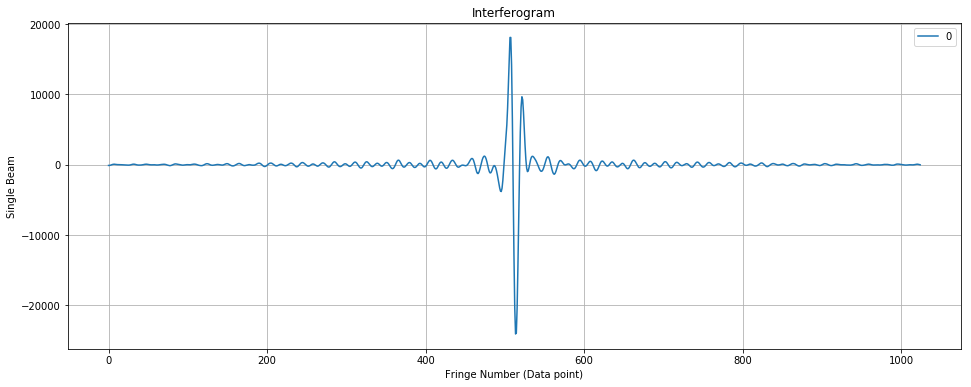

In [144]:
# Raw data interferogram
plt.figure()
for i in range(0, curr.num_acq):
    plt.plot(np.linspace(0, 2*curr.num_pts[i], num=2*curr.num_pts[i]), curr.raw_data[i], label=str(i))
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
plt.title("Interferogram")
plt.legend()
plt.show()